In [60]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patheffects as path_effects
import pandas as pd
import sunpy
import sunpy.map
from sunpy.coordinates import (Helioprojective, propagate_with_solar_surface,
                                HeliocentricEarthEcliptic)
import sunkit_image
import sunkit_image.coalignment as coalignment
import astropy
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
import astropy.units as u
import astropy.constants as const
from astropy.io import fits
from astropy.time import Time
import eispac
import irispy.io
import h5py
from scipy.interpolate import LinearNDInterpolator
from scipy.io import readsav
from datetime import datetime
from regions import PolygonSkyRegion

import cmcrameri.cm as cmcm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import (AutoLocator, AutoMinorLocator, 
    FixedLocator, FixedFormatter, LogLocator, StrMethodFormatter)
from ipywidgets import interactive, widgets
from IPython.display import display, clear_output
from astropy.visualization import (AsinhStretch, LinearStretch,
        LogStretch, ImageNormalize,PowerStretch)
import os
from sun_blinker import SunBlinker
from copy import deepcopy   


In [2]:
eui_map = sunpy.map.Map("../../src/coalign_map/20221024/hri_174_map_shifted_toaia.fits")

In [3]:
eis_195_velmap_derot_repro_shifted_hrifov = sunpy.map.Map("../../src/EIS/DHB_007_v2/20221025T0023/sunpymaps/eis_195_velmap_derot_repro_hrifov.fits")
eis_hhflare_195_velmap_derot_repro_hrifov = sunpy.map.Map("../../src/coalign_map/20221024/eis_hhflare_195_velmap_derot_repro_hrifov.fits")

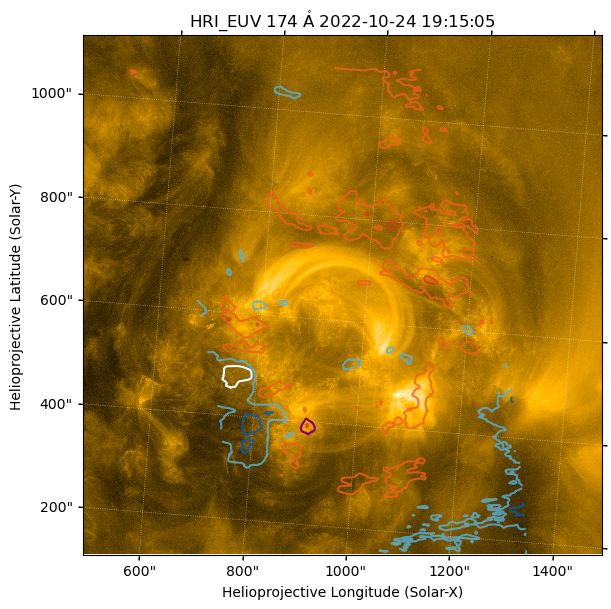

In [4]:
fig = plt.figure(figsize=(6,6),layout="constrained")

ax = fig.add_subplot(111,projection=eui_map.wcs)

eui_map.plot(axes=ax)

cs = eis_195_velmap_derot_repro_shifted_hrifov.draw_contours(levels=[-10,-5,5,10],colors=["#005CAF","#58B2DC","#F05E1C","#E83015"],axes=ax,alpha=0.8)
cs_index = 6
cs_downflow_index = 7
ax.plot(cs.allsegs[0][cs_index][:,0],cs.allsegs[0][cs_index][:,1],color="white")
ax.plot(cs.allsegs[2][cs_downflow_index][:,0],cs.allsegs[2][cs_downflow_index][:,1],color="purple")

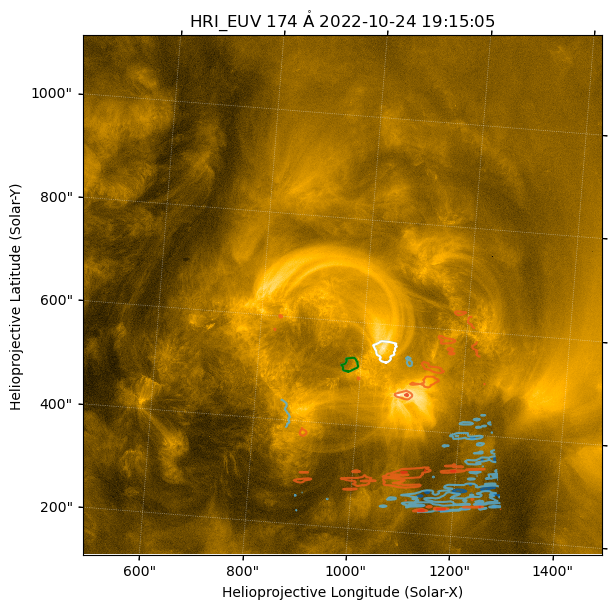

In [5]:
fig = plt.figure(figsize=(6,6),layout="constrained")

ax = fig.add_subplot(111,projection=eui_map.wcs)

eui_map.plot(axes=ax)

cs_hh = eis_hhflare_195_velmap_derot_repro_hrifov.draw_contours(levels=[-10,-5,5,10],colors=["#005CAF","#58B2DC","#F05E1C","#E83015"],axes=ax,alpha=0.8)
cs_hh_index = 43
cs_hh_index_2 = 41
ax.plot(cs_hh.allsegs[1][cs_hh_index][:,0],cs_hh.allsegs[1][cs_hh_index][:,1],color="white")
ax.plot(cs_hh.allsegs[1][cs_hh_index_2][:,0],cs_hh.allsegs[1][cs_hh_index_2][:,1],color="green")

In [6]:
cs_skycoord_east_1 = eui_map.pixel_to_world(cs.allsegs[0][cs_index][:-1,0]*u.pix,cs.allsegs[0][cs_index][:-1,1]*u.pix)

In [7]:
region_east_1 = PolygonSkyRegion(vertices=cs_skycoord_east_1)

In [8]:
cs_skycoord_center_1 = eui_map.pixel_to_world(cs_hh.allsegs[1][cs_hh_index][:-1,0]*u.pix,cs_hh.allsegs[1][cs_hh_index][:-1,1]*u.pix)

In [9]:
region_center_1 = PolygonSkyRegion(vertices=cs_skycoord_center_1)

In [10]:
cs_skycoord_center_2 = eui_map.pixel_to_world(cs_hh.allsegs[1][cs_hh_index_2][:-1,0]*u.pix,cs_hh.allsegs[1][cs_hh_index_2][:-1,1]*u.pix)

In [11]:
region_center_2 = PolygonSkyRegion(vertices=cs_skycoord_center_2)

In [12]:
cs_skycoord_moss = eui_map.pixel_to_world(cs.allsegs[2][cs_downflow_index][:-1,0]*u.pix,cs.allsegs[2][cs_downflow_index][:-1,1]*u.pix)
region_moss = PolygonSkyRegion(vertices=cs_skycoord_moss)

In [13]:
iris_SiIV_1394_velmap = sunpy.map.Map("../../src/IRIS/20221024/2322/fit_res/SiIV_1393_vel_map_shifted.fits")
Txshift_iris_aia_2322, Tyshift_iris_aia_2322 = -9.5438*u.arcsec,0.398957*u.arcsec
iris_SiIV_1394_velmap_rotate = iris_SiIV_1394_velmap.rotate()
iris_SiIV_1394_velmap_rotate_shift = iris_SiIV_1394_velmap_rotate.shift_reference_coord(Txshift_iris_aia_2322,Tyshift_iris_aia_2322)

For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs,dsun_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs,dsun_obs
 [sunpy.map.mapbase]


In [14]:
iris_CII_velmap = sunpy.map.Map("../../src/IRIS/20221024/2322/fit_res/CII_vel_map_shifted.fits")
iris_CII_velmap_rotate = iris_CII_velmap.rotate()
iris_CII_velmap_rotate_shift = iris_CII_velmap_rotate.shift_reference_coord(Txshift_iris_aia_2322,Tyshift_iris_aia_2322)

For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs,dsun_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs,dsun_obs
 [sunpy.map.mapbase]


In [15]:
iris_MgII_k_lc_velmap = sunpy.map.Map("../../src/IRIS/20221024/2322/fit_res/MgII_k_lc_vel_map_shifted.fits")
iris_MgII_k_lc_velmap_rotate = iris_MgII_k_lc_velmap.rotate()
iris_MgII_k_lc_velmap_rotate_shift = iris_MgII_k_lc_velmap_rotate.shift_reference_coord(Txshift_iris_aia_2322,Tyshift_iris_aia_2322)

For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs,dsun_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs,dsun_obs
 [sunpy.map.mapbase]


In [16]:
iris_MgII_k_k2_ratio_map = sunpy.map.Map("../../src/IRIS/20221024/2322/fit_res/MgII_k_k2_ratio_map_shifted.fits")
iris_MgII_k_k2_ratio_map_rotate = iris_MgII_k_k2_ratio_map.rotate()
iris_MgII_k_k2_ratio_map_rotate_shift = iris_MgII_k_k2_ratio_map_rotate.shift_reference_coord(Txshift_iris_aia_2322,Tyshift_iris_aia_2322)

For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs,dsun_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs,dsun_obs
 [sunpy.map.mapbase]


In [17]:
iris_MgII_k_k2_sep_map = sunpy.map.Map("../../src/IRIS/20221024/2322/fit_res/MgII_k_k2_sep_map_shifted.fits")
iris_MgII_k_k2_sep_map_rotate = iris_MgII_k_k2_sep_map.rotate()
iris_MgII_k_k2_sep_map_rotate_shift = iris_MgII_k_k2_sep_map_rotate.shift_reference_coord(Txshift_iris_aia_2322,Tyshift_iris_aia_2322)

For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs,dsun_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs,dsun_obs
 [sunpy.map.mapbase]


In [18]:
iris_SiIV_1394_velmap_rotate_shift_all_coords = sunpy.map.all_coordinates_from_map(iris_SiIV_1394_velmap_rotate_shift)
with propagate_with_solar_surface(rotation_model="rigid"):
    iris_SiIV_1394_velmap_rotate_shift_all_coords_to_hri = iris_SiIV_1394_velmap_rotate_shift_all_coords.transform_to(eui_map.coordinate_frame)
iris_mask_east_1 = np.where(region_east_1.contains(iris_SiIV_1394_velmap_rotate_shift_all_coords_to_hri,eui_map.wcs))
iris_mask_center_1 = np.where(region_center_1.contains(iris_SiIV_1394_velmap_rotate_shift_all_coords_to_hri,eui_map.wcs))
iris_mask_center_2 = np.where(region_center_2.contains(iris_SiIV_1394_velmap_rotate_shift_all_coords_to_hri,eui_map.wcs))
iris_mask_moss = np.where(region_moss.contains(iris_SiIV_1394_velmap_rotate_shift_all_coords_to_hri,eui_map.wcs))

For frame 'heliographic_stonyhurst' the following metadata is missing: hgln_obs,hglt_obs,dsun_obs
For frame 'heliographic_carrington' the following metadata is missing: crlt_obs,crln_obs,dsun_obs
 [sunpy.map.mapbase]


In [19]:
iris_SiIV_vel_center_1 = iris_SiIV_1394_velmap_rotate_shift.data[iris_mask_center_1]
iris_SiIV_vel_center_2 = iris_SiIV_1394_velmap_rotate_shift.data[iris_mask_center_2]
iris_SiIV_vel_moss = iris_SiIV_1394_velmap_rotate_shift.data[iris_mask_moss]

iris_CII_vel_center_1 = iris_CII_velmap_rotate_shift.data[iris_mask_center_1]
iris_CII_vel_center_2 = iris_CII_velmap_rotate_shift.data[iris_mask_center_2]
iris_CII_vel_moss = iris_CII_velmap_rotate_shift.data[iris_mask_moss]

iris_MgII_k_lc_vel_center_1 = iris_MgII_k_lc_velmap_rotate_shift.data[iris_mask_center_1]
iris_MgII_k_lc_vel_center_2 = iris_MgII_k_lc_velmap_rotate_shift.data[iris_mask_center_2]
iris_MgII_k_lc_vel_moss = iris_MgII_k_lc_velmap_rotate_shift.data[iris_mask_moss]

iris_MgII_k_k2_ratio_center_1 = iris_MgII_k_k2_ratio_map_rotate_shift.data[iris_mask_center_1]
iris_MgII_k_k2_ratio_center_2 = iris_MgII_k_k2_ratio_map_rotate_shift.data[iris_mask_center_2]
iris_MgII_k_k2_ratio_moss = iris_MgII_k_k2_ratio_map_rotate_shift.data[iris_mask_moss]

In [90]:
eui_map_crop = eui_map.submap([500,350]*u.pix,top_right=[1500,1350]*u.pix)

Text(0, 0.5, 'Normalized #')

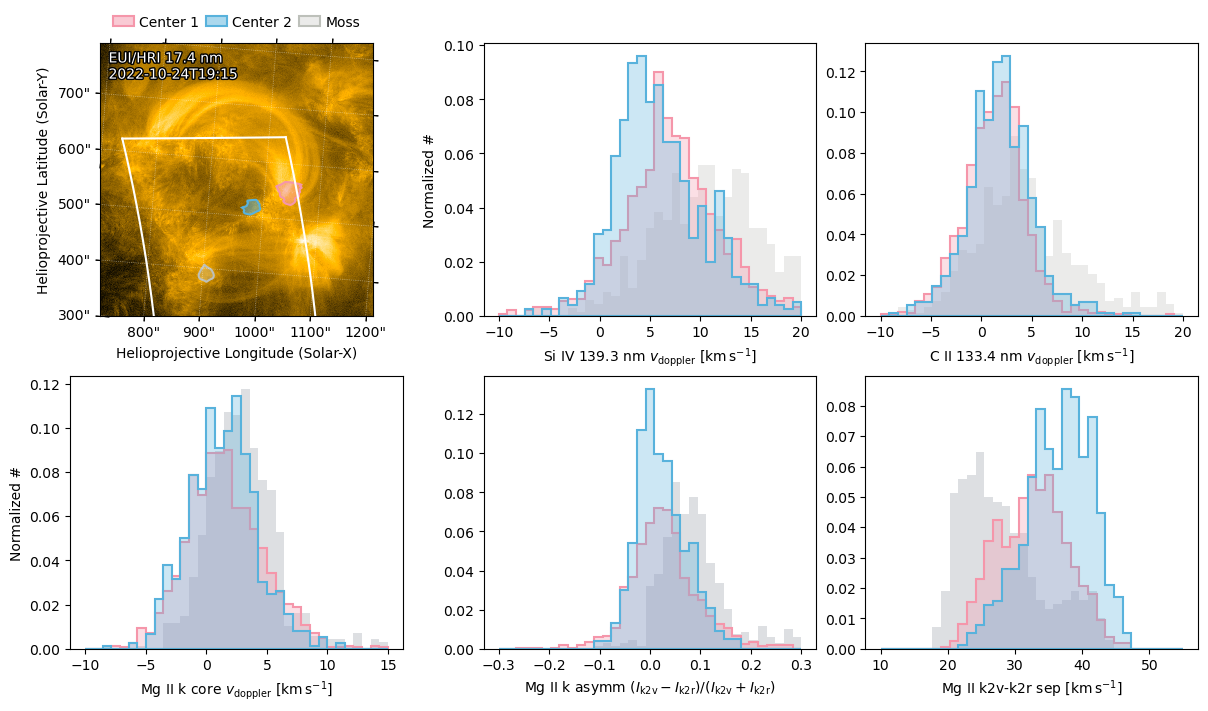

In [104]:
fig = plt.figure(figsize=(12,7),layout="constrained")

ax1 = fig.add_subplot(231,projection=eui_map_crop.wcs)


ax2 = fig.add_subplot(232)
ax3 = fig.add_subplot(233)
ax4 = fig.add_subplot(234)
ax5 = fig.add_subplot(235)
ax6 = fig.add_subplot(236)

eui_map_crop.plot(axes=ax1)
region_center_1.to_pixel(eui_map_crop.wcs).plot(ax=ax1,facecolor=(245./255,150./255,170./255,0.5),fill=True,
                                                edgecolor=(245./255,150./255,170./255,1),lw=1.5,label="Center 1")
region_center_2.to_pixel(eui_map_crop.wcs).plot(ax=ax1,facecolor=(88./255,178./255,220./255,0.5),fill=True,
                                                edgecolor=(88./255,178./255,220./255,1),lw=1.5,label="Center 2")
region_moss.to_pixel(eui_map_crop.wcs).plot(ax=ax1,facecolor=(189./255,192./255,186./255,0.3),fill=True,
                                                edgecolor=(189./255,192./255,186./255,1),lw=1.5,label="Moss")
ax1_bounds = ax1.axis()
with propagate_with_solar_surface(rotation_model="rigid"):
        for edge in sunpy.map.map_edges(iris_SiIV_1394_velmap_rotate_shift):
            edge_coord = iris_SiIV_1394_velmap_rotate_shift.pixel_to_world(edge[:,0],edge[:,1])
            ax1.plot_coord(edge_coord,color="white",lw=1.5)
ax1.set_title(" ")
ax1.axis(ax1_bounds)

ax2.hist(iris_SiIV_vel_moss,bins=35,range=(-10,20),facecolor=(189./255,192./255,186./255,0.3),label="Moss",lw=1.5,
        ls="-",histtype="stepfilled",weights=np.ones_like(iris_SiIV_vel_moss)/len(iris_SiIV_vel_moss))
ax2.hist(iris_SiIV_vel_center_1,bins=35,range=(-10,20),facecolor=(245./255,150./255,170./255,0.3),label="Center 1",lw=1.5,
        ls="-",edgecolor=(245./255,150./255,170./255,1),histtype="stepfilled",weights=np.ones_like(iris_SiIV_vel_center_1)/len(iris_SiIV_vel_center_1))
ax2.hist(iris_SiIV_vel_center_2,bins=35,range=(-10,20),facecolor=(88./255,178./255,220./255,0.3),label="Center 2",lw=1.5,
        ls="-",edgecolor=(88./255,178./255,220./255,1),histtype="stepfilled",weights=np.ones_like(iris_SiIV_vel_center_2)/len(iris_SiIV_vel_center_2))

ax3.hist(iris_CII_vel_moss,bins=35,range=(-10,20),facecolor=(189./255,192./255,186./255,0.3),label="Moss",lw=1.5,
        ls="-",histtype="stepfilled",weights=np.ones_like(iris_CII_vel_moss)/len(iris_CII_vel_moss))
ax3.hist(iris_CII_vel_center_1,bins=35,range=(-10,20),facecolor=(245./255,150./255,170./255,0.3),label="Center 1",lw=1.5,
        ls="-",edgecolor=(245./255,150./255,170./255,1),histtype="stepfilled",weights=np.ones_like(iris_CII_vel_center_1)/len(iris_CII_vel_center_1))
ax3.hist(iris_CII_vel_center_2,bins=35,range=(-10,20),facecolor=(88./255,178./255,220./255,0.3),label="Center 2",lw=1.5,
        ls="-",edgecolor=(88./255,178./255,220./255,1),histtype="stepfilled",weights=np.ones_like(iris_CII_vel_center_2)/len(iris_CII_vel_center_2))

ax4.hist(iris_MgII_k_lc_vel_moss,bins=35,range=(-10,15),facecolor=(145./255,152./255,159./255,0.3),label="Moss",lw=1.5,
        ls="-",histtype="stepfilled",weights=np.ones_like(iris_MgII_k_lc_vel_moss)/len(iris_MgII_k_lc_vel_moss))
ax4.hist(iris_MgII_k_lc_vel_center_1,bins=35,range=(-10,15),facecolor=(245./255,150./255,170./255,0.3),label="Center 1",lw=1.5,
        ls="-",edgecolor=(245./255,150./255,170./255,1),histtype="stepfilled",weights=np.ones_like(iris_MgII_k_lc_vel_center_1)/len(iris_MgII_k_lc_vel_center_1))
ax4.hist(iris_MgII_k_lc_vel_center_2,bins=35,range=(-10,15),facecolor=(88./255,178./255,220./255,0.3),label="Center 2",lw=1.5,
        ls="-",edgecolor=(88./255,178./255,220./255,1),histtype="stepfilled",weights=np.ones_like(iris_MgII_k_lc_vel_center_2)/len(iris_MgII_k_lc_vel_center_2))

ax5.hist(iris_MgII_k_k2_ratio_moss,bins=35,range=(-0.3,0.3),facecolor=(145./255,152./255,159./255,0.3),label="Moss",lw=1.5,
        ls="-",histtype="stepfilled",weights=np.ones_like(iris_MgII_k_k2_ratio_moss)/len(iris_MgII_k_k2_ratio_moss))
ax5.hist(iris_MgII_k_k2_ratio_center_1,bins=35,range=(-0.3,0.3),facecolor=(245./255,150./255,170./255,0.3),label="Center 1",lw=1.5,
        ls="-",edgecolor=(245./255,150./255,170./255,1),histtype="stepfilled",
        weights=np.ones_like(iris_MgII_k_k2_ratio_center_1)/len(iris_MgII_k_k2_ratio_center_1))
ax5.hist(iris_MgII_k_k2_ratio_center_2,bins=35,range=(-0.3,0.3),facecolor=(88./255,178./255,220./255,0.3),label="Center 2",lw=1.5,
        ls="-",edgecolor=(88./255,178./255,220./255,1),histtype="stepfilled",
        weights=np.ones_like(iris_MgII_k_k2_ratio_center_2)/len(iris_MgII_k_k2_ratio_center_2))

ax6.hist(iris_MgII_k_k2_sep_map_rotate_shift.data[iris_mask_moss],bins=35,range=(10,55),facecolor=(145./255,152./255,159./255,0.3),label="Moss",lw=1.5,
        ls="-",histtype="stepfilled",
        weights=np.ones_like(iris_MgII_k_k2_sep_map_rotate_shift.data[iris_mask_moss])/len(iris_MgII_k_k2_sep_map_rotate_shift.data[iris_mask_moss]))
ax6.hist(iris_MgII_k_k2_sep_map_rotate_shift.data[iris_mask_center_1],bins=35,range=(10,55),facecolor=(245./255,150./255,170./255,0.3),label="Center 1",lw=1.5,
        ls="-",edgecolor=(245./255,150./255,170./255,1),histtype="stepfilled",
        weights=np.ones_like(iris_MgII_k_k2_sep_map_rotate_shift.data[iris_mask_center_1])/len(iris_MgII_k_k2_sep_map_rotate_shift.data[iris_mask_center_1]))
ax6.hist(iris_MgII_k_k2_sep_map_rotate_shift.data[iris_mask_center_2],bins=35,range=(10,55),facecolor=(88./255,178./255,220./255,0.3),label="Center 2",lw=1.5,
        ls="-",edgecolor=(88./255,178./255,220./255,1),histtype="stepfilled",
        weights=np.ones_like(iris_MgII_k_k2_sep_map_rotate_shift.data[iris_mask_center_2])/len(iris_MgII_k_k2_sep_map_rotate_shift.data[iris_mask_center_2]))

ax1.legend(bbox_to_anchor=(0.,1.05,1,0.1),ncol=3,mode="expand",handletextpad=0.4,
            handlelength=1.5,frameon=False)
ax1_text= ax1.text(0.03,0.97,"EUI/HRI 17.4 nm\n2022-10-24T19:15",color='white', ha='left', va='top',
        transform=ax1.transAxes)
ax1_text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'),
                       path_effects.Normal()])

ax2.set_xlabel(r"Si IV 139.3 nm $v_{\rm doppler}\ [{\rm km\,s^{-1}}]$",color='black',fontsize=10)
ax3.set_xlabel(r"C II 133.4 nm $v_{\rm doppler}\ [{\rm km\,s^{-1}}]$",color='black',fontsize=10)
ax4.set_xlabel(r"Mg II k core $v_{\rm doppler}\ [{\rm km\,s^{-1}}]$",color='black',fontsize=10)
ax5.set_xlabel(r"Mg II k asymm $(I_{\rm k2v} - I_{\rm k2r})/(I_{\rm k2v} + I_{\rm k2r})$",color='black',fontsize=10)
ax6.set_xlabel(r"Mg II k2v-k2r sep $[{\rm km\,s^{-1}}]$",color='black',fontsize=10)
ax4.set_ylabel(r"Normalized #",fontsize=10)
ax2.set_ylabel(r"Normalized #",fontsize=10)